### Which streets and intersections are associated with the highest percentages of DUIs?

#### Previously I wrote a query in SQL to find the percent of DUIs that take place at each street/intersection in Scottsdale.  Below I'm importing that query into this jupyter notebook, then using python to create a visualization.

In [35]:
# opens SQL query directly in Python, rather than open from CSV
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# SQL query to find the percent of DUIs that take place at each intersection
DUILocations = '''
  select 
	 A.[Street]
	 ,A._Count_
	 ,convert(varchar,
			round(
				 convert(float, A._Count_)/convert(float, B._Total_)*100
				 ,2
			 )
	 ) + '%'as _Percent_
  from    (
		  select 
	      [Street]
		  ,count([Charge Description]) as _Count_
		  from [dbo].[spd_PDCitations$]
		  where [Charge Description] like '%DUI%'
		  group by [Street]
		  
  ) as A

  cross join  (
				select 
			    sum(_Count_) as _Total_
			    from (
				
				  select 
					[Street]
	               ,count([Charge Description]) as _Count_
                   from [dbo].[spd_PDCitations$]
                   where [Charge Description] like '%DUI%'
                   group by [Street]) as C  --interestingly an alias is needed here, even though I'm not calling the alias anywhere else in the querry
 ) as B 
			   
  group by A.[Street], A._Count_, (convert(float, A._Count_)/convert(float, B._Total_)*100)
  
  '''

# save the sql query to a pandas dataframe, or excel like sheet
DUILocations = pd.read_sql(DUILocations, connection)
connection.close()

# remove percent character on the end of '_Percent_' field
DUILocations['_Percent_']= DUILocations['_Percent_'].str.replace('%','')
# convert "Percent" column to numeric data type
DUILocations['_Percent_'] = pd.to_numeric(DUILocations['_Percent_'], errors ='coerce')

DUILocations.sort_values(['_Count_'], ascending=False, inplace=True)
DUILocations.head(10)

,Street,_Count_,_Percent_
128,E Indian School Rd,202,10.76
434,N Scottsdale Rd,138,7.35
54,E Camelback Rd,91,4.85
391,N Hayden Rd / E Indian School Rd,59,3.14
389,N Hayden Rd,56,2.98
200,E Shea Bl,54,2.88
159,E McDowell Rd,43,2.29
62,E Camelback Rd / N Scottsdale Rd,28,1.49
415,N Miller Rd,28,1.49
131,E Indian School Rd / N Miller Rd,25,1.33


In [53]:
# verify correct datatypes
DUILocations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449 entries, 128 to 448
Data columns (total 3 columns):
Street       449 non-null object
_Count_      449 non-null int64
_Percent_    449 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 34.0+ KB


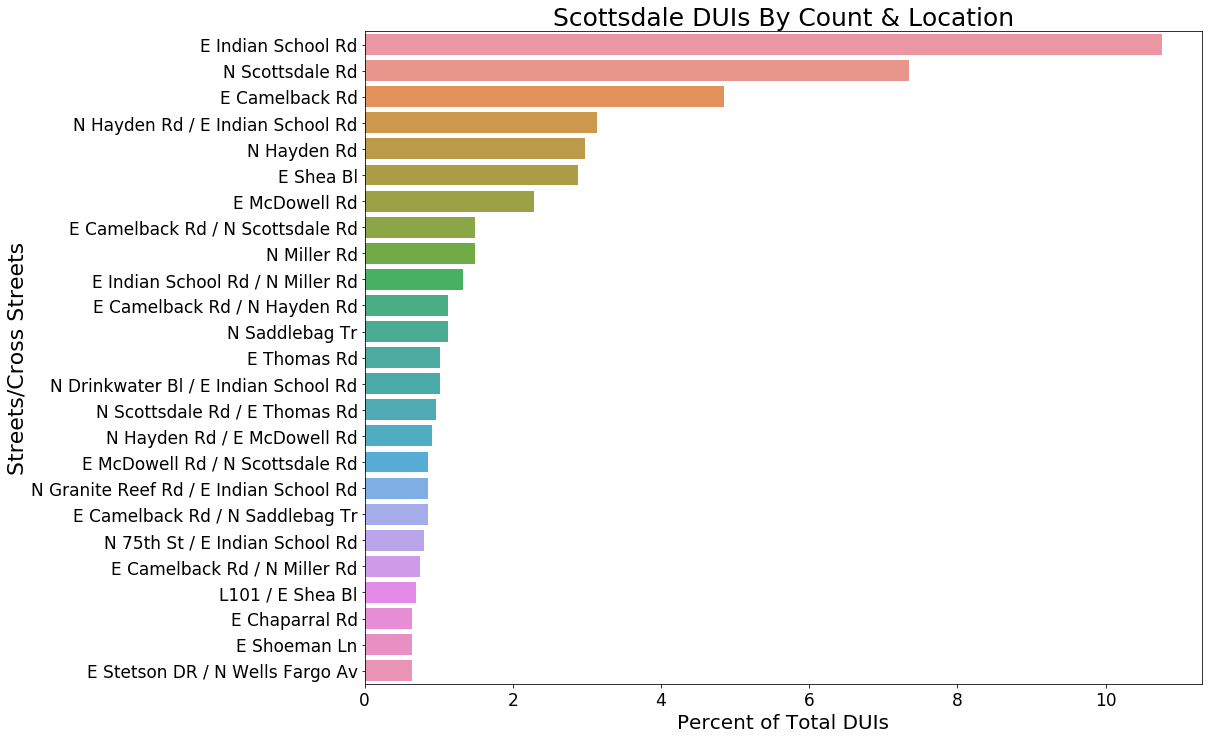

In [56]:
#Plot streets and count of DUIs across Scottsdale
plt.rcParams["figure.figsize"] = [15, 12]    #sets the ploted size

ax = sns.barplot(x=DUILocations['_Percent_'].head(25), 
                 y=DUILocations['Street'].head(25))

plt.title("Scottsdale DUIs By Count & Location",fontsize=25)
plt.xlabel("Percent of Total DUIs",fontsize=20)
plt.ylabel("Streets/Cross Streets",fontsize=22)
plt.tick_params(labelsize=17)